In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import libem
import components as cmp
import realmodel as rlm

from libvis import Visualizations, VideoMaker

### Set up conversion from simulation to real units.

In [3]:
conv = rlm.Conversion(
    mass=1,
    length=1, #cm / sim unit
    time=1,
    charge=1,
    voltage=1
)

# Goal for deflection voltage is 10V for 200eV ions

DFDIM = {
    "length": conv.real_to_sim(4, "length"), # ideal is 3cm
    "box": conv.real_to_sim(2, "length"),
    "diam": conv.real_to_sim(1, "length"),
    "boxwall": conv.real_to_sim(0.2, "length"),

    "panel_l": conv.real_to_sim(1, "length"),
    "panel_w": conv.real_to_sim(1, "length"),
    "panel_h": conv.real_to_sim(0.2, "length")
}

set_panel_sheight = lambda h: h - (DFDIM["box"] / 2.0)

SPACE_SIZE = [round(DFDIM["length"] * 1.5), round(DFDIM["box"] * 1.5), round(DFDIM["box"] * 1.5)]
SPACE_TLFT = [-(s / 2.0) for s in SPACE_SIZE]

SCALE = 10

print("SIMULATION SPACE SIZE:", ", ".join([str(s) for s in SPACE_SIZE]))
print("SIMULATION SPACE TOP_LEFT:", ", ".join([str(tl) for tl in SPACE_TLFT]))
print("SIMULATION SCALE SET AT:", SCALE)


SIMULATION SPACE SIZE: 6, 3, 3
SIMULATION SPACE TOP_LEFT: -3.0, -1.5, -1.5
SIMULATION SCALE SET AT: 10


### Deflection gate generator function

In [4]:
def generate_dfgate(panel_pos, body_V, hole_V, panel_V):
    # Create simulation space from global parameters
    sim = libem.EMSimulationSpace3D(space_size=SPACE_SIZE, top_left=SPACE_TLFT, scale=SCALE)

    # CREATE GATE COMPONENTS
    # Body - Hollow Rectangular Prism
    body = (
        (-(DFDIM["length"] / 2.0), -(DFDIM["box"] / 2.0), -(DFDIM["box"] / 2.0)),
        (DFDIM["length"], DFDIM["box"], DFDIM["box"]),
        DFDIM["boxwall"],
        body_V
    )
    # End Holes - Closed Cylinders
    ehole_0_mask = cmp.EMObjectMasks.closed_cylinder_in_plane(
        sim,
        (-(DFDIM["length"] / 2.0), 0, 0),
        DFDIM["diam"] / 2.0,
        DFDIM["boxwall"],
        0
    )
    ehole_1_mask = cmp.EMObjectMasks.closed_cylinder_in_plane(
        sim,
        ((DFDIM["length"] / 2.0), 0, 0),
        DFDIM["diam"] / 2.0,
        DFDIM["boxwall"],
        0,
        direction=-1
    )
    # Deflection Panel - Rectangular Prism
    panel = (
        panel_pos,
        (DFDIM["panel_l"], DFDIM["panel_w"], DFDIM["panel_h"]),
        panel_V
    )

    # Generate boundary enforcer
    enf = cmp.make_enforcer(
        cmp.enf(cmp.EMObjects.rectangular_prism_hollow, *body),
        cmp.enf(cmp.EMObjects.arbitrary_mask, ehole_0_mask, hole_V),
        cmp.enf(cmp.EMObjects.arbitrary_mask, ehole_1_mask, hole_V),
        cmp.enf(cmp.EMObjects.rectangular_prism_solid, *panel)
    )

    return sim, enf


### Visualization of the deflector gate

Visualizing the deflection gate
 - Computing electric field
 - Rendering 3D Electric Field


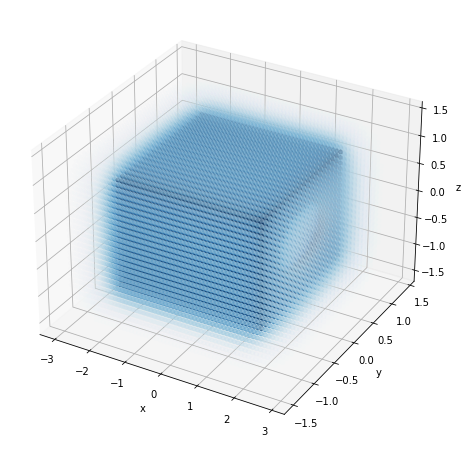

 - Rendering 2D Electric Field Cross-Sections at 0


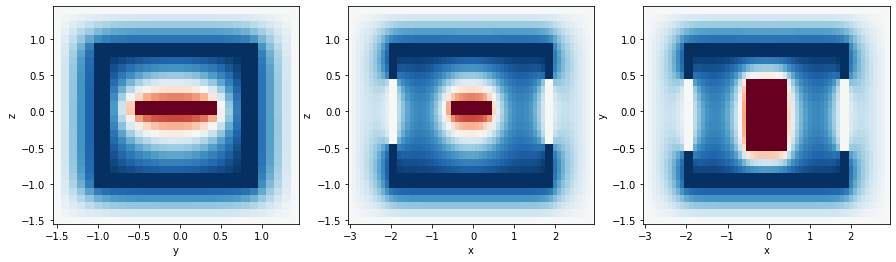

In [5]:
def visualize_dfgate(panel_pos, body_V, hole_V, panel_V):
    V_norm = max(panel_V, hole_V, body_V)

    print("Visualizing the deflection gate")
    sim, enf = generate_dfgate(panel_pos, body_V, hole_V, panel_V)
    print(" - Computing electric field")
    sim.compute(enf)
    print(" - Rendering 3D Electric Field")

    Visualizations.colormesh_3d(sim, size=(10, 8), resolution=1, color_norm=V_norm)

    print(" - Rendering 2D Electric Field Cross-Sections at 0")

    _, axs = plt.subplots(1, 3, figsize=(15, 4))
    labels = ["x", "y", "z"]
    for i, ax in enumerate(axs):
        sub_label = labels[:]
        sub_label.pop(i)
        ax.set_xlabel(sub_label[0])
        ax.set_ylabel(sub_label[1])

        sim2d = libem.EMSimulationSpace2D.from_3d(sim, axis=i, location=0)
        Visualizations.colormesh_2d(sim2d, color_norm=V_norm, graph_ax=ax)

visualize_dfgate(
    (-(DFDIM["panel_l"] / 2.0), -(DFDIM["panel_w"] / 2.0), (set_panel_sheight(DFDIM["box"] / 2.0))),
    1, 0, -1
)


### Particle Path Visualization through Deflector

Visualizing the deflection gate with particle path.
 - Computing electric field
 - Computing particle motion
 - Rendering 2D Electric Field Cross-Sections at 0 with Motion


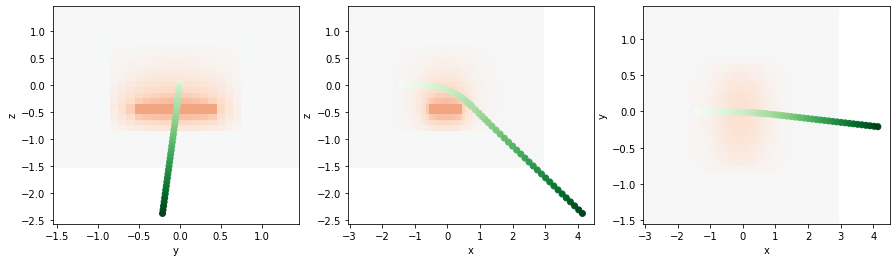

In [14]:
PARTICLE_OPTS = {
    "mass": (1, 0),
    "charge": (1, 0),
    "initial_loc": ((-1.4, 0, 0), (0, 0, 0)),
    "initial_v": ((1, 0, 0), (0.2, 0.05, 0.05)),
    "bounce_coef": None
}

def visualize_dfgate_particle(particle_opts, panel_pos, body_V, hole_V, panel_V):
    V_norm = max(panel_V, hole_V, body_V, 1)

    print("Visualizing the deflection gate with particle path.")
    sim, enf = generate_dfgate(panel_pos, body_V, hole_V, panel_V)
    print(" - Computing electric field")
    sim.compute(enf)
    sim.get_efield()
    print(" - Computing particle motion")
    particle = libem.ChargedParticle3D(sim, particle_opts["mass"][0], particle_opts["charge"][0],
                                       (particle_opts["initial_loc"][0][0], 0, 0),
                                       particle_opts["initial_v"][0], bounce=particle_opts["bounce_coef"])
    particle.compute_motion((0, (DFDIM["length"] * 1.5) / particle_opts["initial_v"][0][0]))
    print(" - Rendering 2D Electric Field Cross-Sections at 0 with Motion")

    _, axs = plt.subplots(1, 3, figsize=(15, 4))
    labels = ["x", "y", "z"]
    for i, ax in enumerate(axs):
        sub_label = labels[:]
        sub_label.pop(i)
        ax.set_xlabel(sub_label[0])
        ax.set_ylabel(sub_label[1])

        sim2d = libem.EMSimulationSpace2D.from_3d(sim, axis=i, location=0)
        Visualizations.colormesh_2d(sim2d, color_norm=V_norm, graph_ax=ax)
        Visualizations.trajectory_2d(particle.time, particle.position, axis=i, graph_ax=ax)


visualize_dfgate_particle(
    PARTICLE_OPTS,
    (-(DFDIM["panel_l"] / 2.0), -(DFDIM["panel_w"] / 2.0), (set_panel_sheight(0.5))),
    0, 0, -0.4
)

### 